# Operation-Based Bit Array Fuzzing

Instead of directly providing bit arrays, we use operations that transform a bit array starting from all zeros. This makes reaching specific values much harder and creates natural plateaus in coverage.

In [83]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

class BitArrayOperations:
    """
    Operations that can be applied to a bit array.
    Starting from all zeros, n operations should be able to reach any value in [0, 2^n).
    """
    
    @staticmethod
    def flip(bits, pos):
        """Flip bit at position pos"""
        if 0 <= pos < len(bits):
            bits[pos] = 1 - bits[pos]
        return bits
    
    @staticmethod
    def set_bit(bits, pos):
        """Set bit at position pos to 1"""
        if 0 <= pos < len(bits):
            bits[pos] = 1
        return bits
    
    @staticmethod
    def clear_bit(bits, pos):
        """Clear bit at position pos to 0"""
        if 0 <= pos < len(bits):
            bits[pos] = 0
        return bits
    
    @staticmethod
    def shift_left(bits):
        """Shift all bits left by 1, losing leftmost bit"""
        if len(bits) > 0:
            return bits[1:] + [0]
        return bits
    
    @staticmethod
    def shift_right(bits):
        """Shift all bits right by 1, losing rightmost bit"""
        if len(bits) > 0:
            return [0] + bits[:-1]
        return bits
    
    @staticmethod
    def rotate_left(bits):
        """Rotate bits left by 1"""
        if len(bits) > 0:
            return bits[1:] + [bits[0]]
        return bits
    
    @staticmethod
    def rotate_right(bits):
        """Rotate bits right by 1"""
        if len(bits) > 0:
            return [bits[-1]] + bits[:-1]
        return bits
    
    @staticmethod
    def increment(bits):
        """Increment the bit array as a binary number"""
        carry = 1
        for i in range(len(bits) - 1, -1, -1):
            if carry:
                if bits[i] == 0:
                    bits[i] = 1
                    carry = 0
                else:
                    bits[i] = 0
        return bits
    
    @staticmethod
    def decrement(bits):
        """Decrement the bit array as a binary number"""
        borrow = 1
        for i in range(len(bits) - 1, -1, -1):
            if borrow:
                if bits[i] == 1:
                    bits[i] = 0
                    borrow = 0
                else:
                    bits[i] = 1
        return bits

# Operation mapping
OPERATIONS = {
    'flip': BitArrayOperations.flip,
    'set': BitArrayOperations.set_bit,
    'clear': BitArrayOperations.clear_bit,
    'shift_left': BitArrayOperations.shift_left,
    'shift_right': BitArrayOperations.shift_right,
    'rotate_left': BitArrayOperations.rotate_left,
    'rotate_right': BitArrayOperations.rotate_right,
    'increment': BitArrayOperations.increment,
    'decrement': BitArrayOperations.decrement,
}

def apply_operations(operations, n):
    """
    Apply a list of operations to a bit array of size n, starting from all zeros.
    
    Args:
        operations: List of (op_name, arg) tuples. arg is position for positional ops, None otherwise
        n: Size of bit array
    
    Returns:
        Resulting bit array
    """
    bits = [0] * n
    for op_name, arg in operations:
        if op_name in OPERATIONS:
            op_func = OPERATIONS[op_name]
            if arg is not None:
                bits = op_func(bits, arg)
            else:
                bits = op_func(bits)
    return bits

def bits_to_int(bits):
    """Convert bit array to integer"""
    result = 0
    for bit in bits:
        result = (result << 1) | bit
    return result

## Test Operations

Let's verify that operations work and can reach different values:

In [84]:
# Test reaching different values
n = 8

# Reach value 5 (binary: 00000101)
ops1 = [('set', 6), ('set', 4)]  # Set positions 6 and 4
result1 = apply_operations(ops1, n)
print(f"Operations {ops1}")
print(f"Result: {result1} -> {bits_to_int(result1)}")

# Reach value 15 using increment (binary: 00001111)
ops2 = [('increment', None)] * 15
result2 = apply_operations(ops2, n)
print(f"\n15 increments")
print(f"Result: {result2} -> {bits_to_int(result2)}")

# Reach value 255 using all sets (binary: 11111111)
ops3 = [('set', i) for i in range(n)]
result3 = apply_operations(ops3, n)
print(f"\nSet all bits")
print(f"Result: {result3} -> {bits_to_int(result3)}")

# Complex sequence
ops4 = [('set', 0), ('shift_left', None), ('set', 7), ('increment', None)]
result4 = apply_operations(ops4, n)
print(f"\nComplex: {ops4}")
print(f"Result: {result4} -> {bits_to_int(result4)}")

Operations [('set', 6), ('set', 4)]
Result: [0, 0, 0, 0, 1, 0, 1, 0] -> 10

15 increments
Result: [0, 0, 0, 0, 1, 1, 1, 1] -> 15

Set all bits
Result: [1, 1, 1, 1, 1, 1, 1, 1] -> 255

Complex: [('set', 0), ('shift_left', None), ('set', 7), ('increment', None)]
Result: [0, 0, 0, 0, 0, 0, 1, 0] -> 2


## Operation-Based Fuzzer

Now create a fuzzer that generates random operation sequences and tracks coverage:

In [85]:
class OperationBasedFuzzer:
    def __init__(self, n=8, max_ops_per_sequence=10, reset_on_drift=False):
        self.n = n  # Bit array size
        self.max_ops = max_ops_per_sequence
        self.reset_on_drift = reset_on_drift  # Whether to reset corpus on drift
        self.coverage = set()  # Track unique values reached
        self.corpus = []  # Store operation sequences that found new coverage
        self.iterations = []
        self.coverage_over_time = []
        self.plateau_threshold = 100  # Iterations without improvement = plateau
        
        # Concept drift detection
        self.window_size = 100  # Window for drift detection
        self.drift_threshold = 0.05  # KS test p-value threshold
        self.value_history = []  # Track discovered values over time
        self.coverage_rate_history = []  # Track coverage rate over time
        self.drift_points = []  # Store (iteration, drift_type) tuples
        self.corpus_resets = []  # Track when corpus was reset
        self.last_window_values = []
        self.last_window_coverage_rates = []
        
        # Operation names that need position argument
        self.positional_ops = {'flip', 'set', 'clear'}
        self.non_positional_ops = {'shift_left', 'shift_right', 'rotate_left', 
                                   'rotate_right', 'increment', 'decrement'}
        
    def generate_random_operation(self):
        """Generate a single random operation"""
        # Choose operation type
        all_ops = list(self.positional_ops | self.non_positional_ops)
        op_name = random.choice(all_ops)
        
        # Generate argument if needed
        if op_name in self.positional_ops:
            arg = random.randint(0, self.n - 1)
        else:
            arg = None
            
        return (op_name, arg)
    
    def generate_random_sequence(self):
        """Generate a random sequence of operations"""
        num_ops = random.randint(1, self.max_ops)
        return [self.generate_random_operation() for _ in range(num_ops)]
    
    def mutate_sequence(self, ops):
        """Mutate an operation sequence (keeping constant length)"""
        mutated = ops.copy()
        mutation_type = random.choice(['modify', 'swap'])
        
        if mutation_type == 'modify' and len(mutated) > 0:
            # Modify a random operation
            pos = random.randint(0, len(mutated) - 1)
            mutated[pos] = self.generate_random_operation()
            
        elif mutation_type == 'swap' and len(mutated) > 1:
            # Swap two operations
            pos1 = random.randint(0, len(mutated) - 1)
            pos2 = random.randint(0, len(mutated) - 1)
            mutated[pos1], mutated[pos2] = mutated[pos2], mutated[pos1]
        
        return mutated
    
    def evaluate_sequence(self, ops):
        """Apply operations and return the resulting value"""
        bits = apply_operations(ops, self.n)
        value = bits_to_int(bits)
        return value, bits
    
    def is_coverage_rate_increasing(self):
        """
        Check if coverage rate is increasing compared to the past window.
        Returns True if current window has higher average coverage rate than previous window.
        """
        if len(self.coverage_rate_history) < self.window_size * 2:
            return True  # Not enough data, assume increasing
        
        # Get current and previous windows
        current_window_start = len(self.coverage_rate_history) - self.window_size
        previous_window_start = current_window_start - self.window_size
        
        current_rates = self.coverage_rate_history[current_window_start:]
        previous_rates = self.coverage_rate_history[previous_window_start:current_window_start]
        
        # Compare average coverage rates
        avg_current = np.mean(current_rates)
        avg_previous = np.mean(previous_rates)
        
        return avg_current > avg_previous
    
    def detect_concept_drift(self, current_iter):
        """
        Detect concept drift using KS test on two types of data:
        1. Value distribution drift
        2. Coverage rate drift
        """
        if len(self.value_history) < self.window_size * 2:
            return  # Not enough data yet
        
        # Get current and previous windows
        current_window_start = len(self.value_history) - self.window_size
        previous_window_start = current_window_start - self.window_size
        
        current_values = self.value_history[current_window_start:]
        previous_values = self.value_history[previous_window_start:current_window_start]
        
        current_coverage_rates = self.coverage_rate_history[current_window_start:]
        previous_coverage_rates = self.coverage_rate_history[previous_window_start:current_window_start]
        
        # KS test for value distribution
        ks_stat_values, p_value_values = stats.ks_2samp(previous_values, current_values)
        
        # KS test for coverage rate
        ks_stat_coverage, p_value_coverage = stats.ks_2samp(
            previous_coverage_rates, current_coverage_rates
        )
        
        # Detect drift if p-value is below threshold (only value distribution)
        if p_value_values < self.drift_threshold:
            self.drift_points.append((current_iter, 'value_distribution'))
            print(f"Iter {current_iter:5d}: CONCEPT DRIFT DETECTED (value_distribution) | "
                  f"KS p-value: {p_value_values:.4f}")
            
            # Check if coverage rate is increasing
            is_increasing = self.is_coverage_rate_increasing()
            print(f"Iter {current_iter:5d}: Coverage rate increasing: {is_increasing}")
            
            # Reset corpus if option is enabled AND coverage rate is not increasing
            if self.reset_on_drift and not is_increasing:
                old_corpus_size = len(self.corpus)
                self.corpus = []
                self.corpus_resets.append(current_iter)
                print(f"Iter {current_iter:5d}: CORPUS RESET - Cleared {old_corpus_size} sequences "
                      f"(coverage rate not increasing)")
            elif self.reset_on_drift and is_increasing:
                print(f"Iter {current_iter:5d}: NO RESET - Coverage rate is increasing, keeping corpus")

    
    def fuzz(self, iterations=5000):
        """Run the fuzzing campaign"""
        print(f"Starting operation-based fuzzing for {iterations} iterations...")
        print(f"Bit array size: {self.n}, Max operations per sequence: {self.max_ops}")
        print(f"Target: Discover all values in [0, {2**self.n})")
        print(f"Concept drift detection: Window size={self.window_size}, "
              f"KS threshold p-value={self.drift_threshold}")
        print(f"Corpus reset on drift: {self.reset_on_drift}")
        print("-" * 70)
        
        iterations_since_improvement = 0
        
        for i in range(iterations):
            # Choose generation strategy
            if not self.corpus or random.random() < 0.3:
                # 30% random generation
                ops = self.generate_random_sequence()
            else:
                # 70% mutate from corpus
                seed_ops = random.choice(self.corpus)
                ops = self.mutate_sequence(seed_ops)
            
            # Evaluate the sequence
            value, bits = self.evaluate_sequence(ops)
            
            # Track value and coverage rate for drift detection
            self.value_history.append(value)
            current_coverage_rate = len(self.coverage) / (i + 1) if i > 0 else 0
            self.coverage_rate_history.append(current_coverage_rate)
            
            # Check for new coverage
            is_new = value not in self.coverage
            if is_new:
                self.coverage.add(value)
                self.corpus.append(ops)
                iterations_since_improvement = 0
                
                # Report progress periodically
                if len(self.coverage) % 10 == 0:
                    print(f"Iter {i:5d}: Coverage {len(self.coverage):3d}/{2**self.n} "
                          f"({100*len(self.coverage)/2**self.n:.1f}%) | "
                          f"Found value {value}")
            else:
                iterations_since_improvement += 1
            
            # Track metrics
            self.iterations.append(i)
            self.coverage_over_time.append(len(self.coverage))
            
            # Detect concept drift every window_size iterations
            if (i + 1) % self.window_size == 0:
                self.detect_concept_drift(i)
            
            # Detect plateau
            if iterations_since_improvement > 0 and iterations_since_improvement % self.plateau_threshold == 0:
                print(f"Iter {i:5d}: PLATEAU - No improvement for {iterations_since_improvement} iterations "
                      f"(Coverage: {len(self.coverage)}/{2**self.n})")
        
        print("-" * 70)
        print(f"Fuzzing complete!")
        print(f"Total coverage: {len(self.coverage)}/{2**self.n} values "
              f"({100*len(self.coverage)/2**self.n:.1f}%)")
        print(f"Corpus size: {len(self.corpus)}")
        print(f"Concept drifts detected: {len(self.drift_points)}")
        if self.reset_on_drift:
            print(f"Corpus resets: {len(self.corpus_resets)}")
        
        # Show what values are missing
        all_values = set(range(2**self.n))
        missing = sorted(all_values - self.coverage)
        if missing:
            print(f"\nMissing values ({len(missing)}): {missing[:20]}{'...' if len(missing) > 20 else ''}")
    
    def plot_coverage(self):
        """Visualize coverage growth over time with drift detection markers"""
        plt.figure(figsize=(12, 6))
        plt.plot(self.iterations, self.coverage_over_time, linewidth=2, color='darkblue')
        plt.axhline(y=2**self.n, color='red', linestyle='--', alpha=0.5, 
                   label=f'Maximum possible ({2**self.n})')
        
        # Mark concept drift points (value distribution only)
        if self.drift_points:
            value_drift_iters = [i for i, t in self.drift_points if t == 'value_distribution']
            
            if value_drift_iters:
                value_drift_coverage = [self.coverage_over_time[i] for i in value_drift_iters]
                plt.scatter(value_drift_iters, value_drift_coverage, 
                           color='orange', s=150, marker='^', zorder=5, 
                           label='Value Distribution Drift', alpha=0.8, edgecolors='black')
        
        # Mark corpus resets
        if self.reset_on_drift and self.corpus_resets:
            reset_coverage = [self.coverage_over_time[i] for i in self.corpus_resets]
            plt.scatter(self.corpus_resets, reset_coverage,
                       color='red', s=150, marker='X', zorder=5,
                       label='Corpus Reset', alpha=0.8, edgecolors='black')
        
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Unique Values Discovered', fontsize=12)
        title = 'Coverage Growth with Concept Drift Detection'
        if self.reset_on_drift:
            title += ' (Corpus Reset Enabled)'
        plt.title(title, fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

Starting operation-based fuzzing for 20000 iterations...
Bit array size: 10, Max operations per sequence: 5
Target: Discover all values in [0, 1024)
Concept drift detection: Window size=100, KS threshold p-value=0.05
Corpus reset on drift: False
----------------------------------------------------------------------
Iter    21: Coverage  10/1024 (1.0%) | Found value 1023
Iter    42: Coverage  20/1024 (2.0%) | Found value 95
Iter    60: Coverage  30/1024 (2.9%) | Found value 516
Iter    94: Coverage  40/1024 (3.9%) | Found value 37
Iter   141: Coverage  50/1024 (4.9%) | Found value 12
Iter   200: Coverage  60/1024 (5.9%) | Found value 40
Iter   249: Coverage  70/1024 (6.8%) | Found value 911
Iter   304: Coverage  80/1024 (7.8%) | Found value 1014
Iter   333: Coverage  90/1024 (8.8%) | Found value 13
Iter   376: Coverage 100/1024 (9.8%) | Found value 195
Iter   413: Coverage 110/1024 (10.7%) | Found value 222
Iter   461: Coverage 120/1024 (11.7%) | Found value 526
Iter   516: Coverage 130

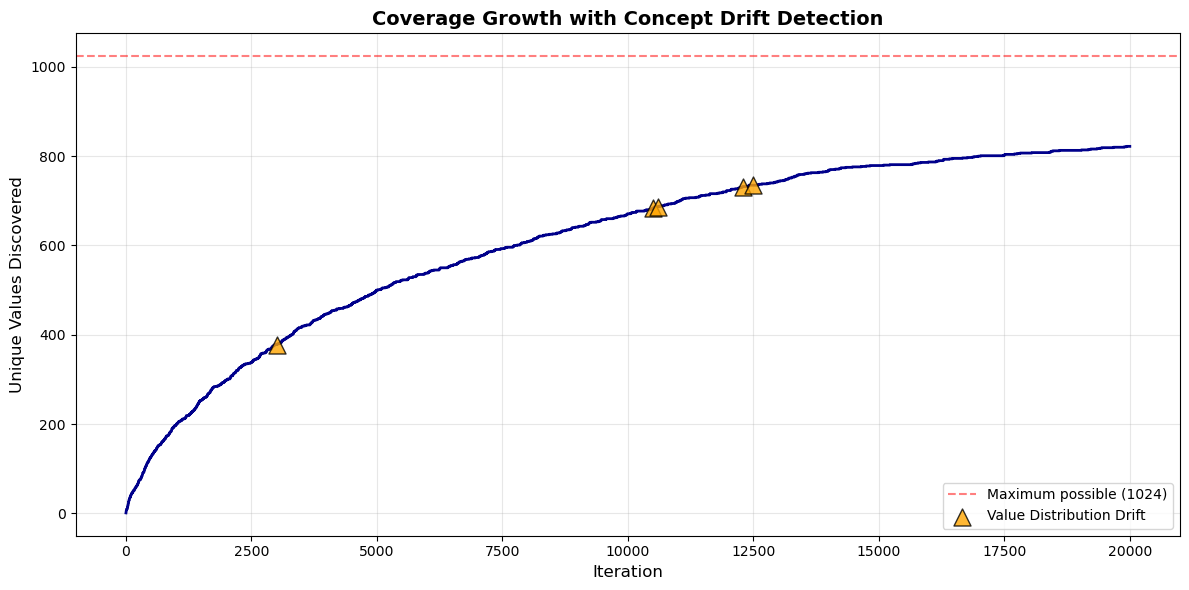

In [86]:
# Run the operation-based fuzzer
fuzzer = OperationBasedFuzzer(n=10, max_ops_per_sequence=5)
fuzzer.fuzz(iterations=20000)
fuzzer.plot_coverage()

## Comparison: With vs Without Corpus Reset

Compare fuzzing performance with and without corpus reset after drift detection:

In [87]:
# Run both versions and compare
print("=" * 80)
print("EXPERIMENT 1: WITHOUT Corpus Reset")
print("=" * 80)
fuzzer_no_reset = OperationBasedFuzzer(n=10, max_ops_per_sequence=5, reset_on_drift=False)
fuzzer_no_reset.fuzz(iterations=20000)

print("\n\n")
print("=" * 80)
print("EXPERIMENT 2: WITH Corpus Reset on Drift")
print("=" * 80)
fuzzer_with_reset = OperationBasedFuzzer(n=10, max_ops_per_sequence=5, reset_on_drift=True)
fuzzer_with_reset.fuzz(iterations=20000)

EXPERIMENT 1: WITHOUT Corpus Reset
Starting operation-based fuzzing for 20000 iterations...
Bit array size: 10, Max operations per sequence: 5
Target: Discover all values in [0, 1024)
Concept drift detection: Window size=100, KS threshold p-value=0.05
Corpus reset on drift: False
----------------------------------------------------------------------
Iter    21: Coverage  10/1024 (1.0%) | Found value 15
Iter    49: Coverage  20/1024 (2.0%) | Found value 321
Iter    98: Coverage  30/1024 (2.9%) | Found value 640
Iter   148: Coverage  40/1024 (3.9%) | Found value 5
Iter   199: Coverage  50/1024 (4.9%) | Found value 31
Iter   274: Coverage  60/1024 (5.9%) | Found value 990
Iter   331: Coverage  70/1024 (6.8%) | Found value 146
Iter   430: Coverage  80/1024 (7.8%) | Found value 772
Iter   529: Coverage  90/1024 (8.8%) | Found value 770
Iter   640: Coverage 100/1024 (9.8%) | Found value 580
Iter   728: Coverage 110/1024 (10.7%) | Found value 68
Iter   813: Coverage 120/1024 (11.7%) | Found v

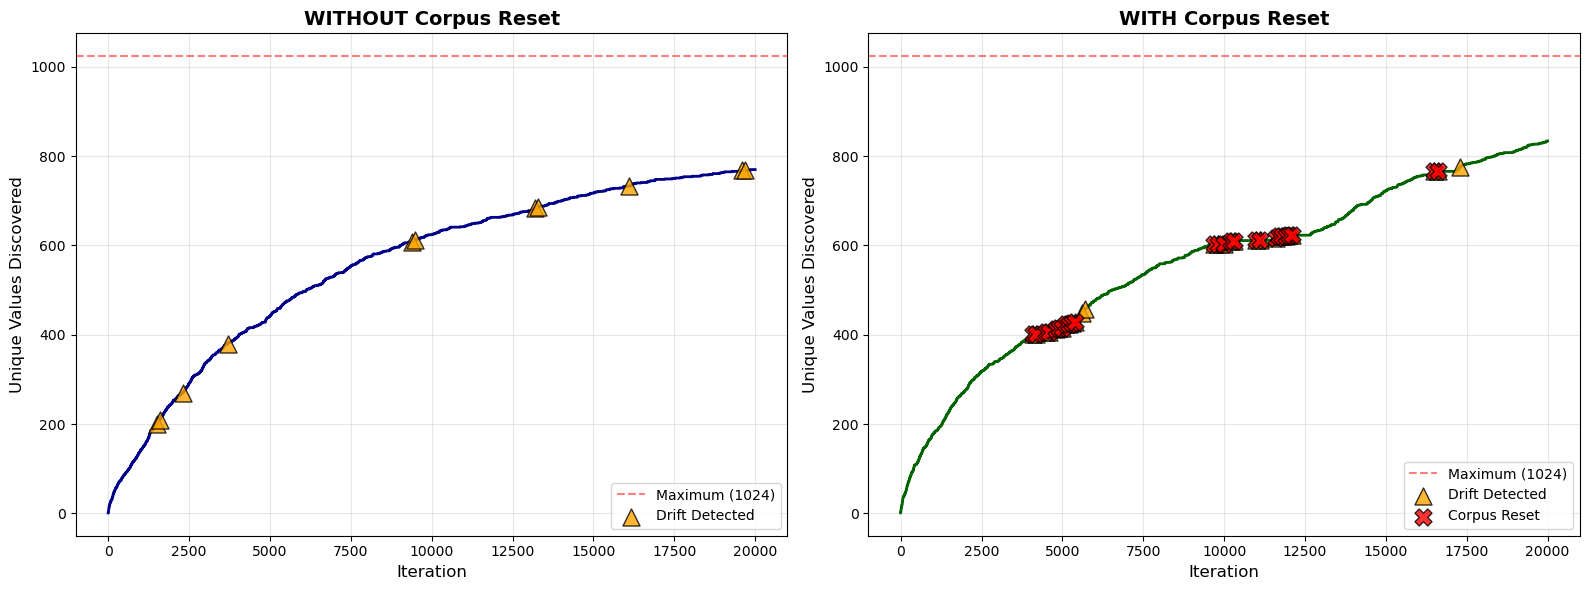


COMPARISON SUMMARY
Without Reset - Final Coverage: 770/1024 (75.2%)
With Reset    - Final Coverage: 834/1024 (81.4%)

Drifts detected: No Reset=11, With Reset=29
Corpus resets performed: 26

Final corpus size: No Reset=770, With Reset=68

Coverage difference: +64 values (better with reset)


In [88]:
# Side-by-side comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Without reset
ax1.plot(fuzzer_no_reset.iterations, fuzzer_no_reset.coverage_over_time, 
         linewidth=2, color='darkblue')
ax1.axhline(y=2**fuzzer_no_reset.n, color='red', linestyle='--', alpha=0.5, 
           label=f'Maximum ({2**fuzzer_no_reset.n})')
if fuzzer_no_reset.drift_points:
    drift_iters = [i for i, t in fuzzer_no_reset.drift_points]
    drift_coverage = [fuzzer_no_reset.coverage_over_time[i] for i in drift_iters]
    ax1.scatter(drift_iters, drift_coverage, color='orange', s=150, marker='^', 
               zorder=5, label='Drift Detected', alpha=0.8, edgecolors='black')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Unique Values Discovered', fontsize=12)
ax1.set_title('WITHOUT Corpus Reset', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: With reset
ax2.plot(fuzzer_with_reset.iterations, fuzzer_with_reset.coverage_over_time, 
         linewidth=2, color='darkgreen')
ax2.axhline(y=2**fuzzer_with_reset.n, color='red', linestyle='--', alpha=0.5, 
           label=f'Maximum ({2**fuzzer_with_reset.n})')
if fuzzer_with_reset.drift_points:
    drift_iters = [i for i, t in fuzzer_with_reset.drift_points]
    drift_coverage = [fuzzer_with_reset.coverage_over_time[i] for i in drift_iters]
    ax2.scatter(drift_iters, drift_coverage, color='orange', s=150, marker='^', 
               zorder=5, label='Drift Detected', alpha=0.8, edgecolors='black')
if fuzzer_with_reset.corpus_resets:
    reset_coverage = [fuzzer_with_reset.coverage_over_time[i] for i in fuzzer_with_reset.corpus_resets]
    ax2.scatter(fuzzer_with_reset.corpus_resets, reset_coverage, color='red', 
               s=150, marker='X', zorder=5, label='Corpus Reset', alpha=0.8, edgecolors='black')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Unique Values Discovered', fontsize=12)
ax2.set_title('WITH Corpus Reset', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "=" * 80)
print("COMPARISON SUMMARY")
print("=" * 80)
print(f"Without Reset - Final Coverage: {len(fuzzer_no_reset.coverage)}/{2**fuzzer_no_reset.n} "
      f"({100*len(fuzzer_no_reset.coverage)/2**fuzzer_no_reset.n:.1f}%)")
print(f"With Reset    - Final Coverage: {len(fuzzer_with_reset.coverage)}/{2**fuzzer_with_reset.n} "
      f"({100*len(fuzzer_with_reset.coverage)/2**fuzzer_with_reset.n:.1f}%)")
print(f"\nDrifts detected: No Reset={len(fuzzer_no_reset.drift_points)}, "
      f"With Reset={len(fuzzer_with_reset.drift_points)}")
print(f"Corpus resets performed: {len(fuzzer_with_reset.corpus_resets)}")
print(f"\nFinal corpus size: No Reset={len(fuzzer_no_reset.corpus)}, "
      f"With Reset={len(fuzzer_with_reset.corpus)}")

improvement = len(fuzzer_with_reset.coverage) - len(fuzzer_no_reset.coverage)
print(f"\nCoverage difference: {improvement:+d} values "
      f"({'better' if improvement > 0 else 'worse'} with reset)")